# A short demo to show how B converges to the data-specific pseudoinverse of W

In [1]:
import torch
import torchvision
import numpy as np

Here we will show how gradient descent on the energy E = 1/2 ||r - B W r||^2 aligns B with the data-specific pseudoinverse of W. In this demo, we keep W fixed and assume only one data vector r.

In [2]:
# define the update rule for B
def update_B(r, W, B):
    grad_B = np.outer((- r + B @ W @ r), (W @ r).T)
    return grad_B

# define the data-specific pseudoinverse of W given the data vector r
def ds_pinv(r, W):
    gen_pseudo = np.outer(r,r.T) @ W.T / np.linalg.norm(W @ r)**2
    return gen_pseudo

# define the mismatch energy
def mismatch_energy(r, W, B):
    return .5 * np.linalg.norm(r - B @ W @ r)

# Calculate the cosine similarity between two tensors
# using the Frobenius inner product
def cosine_similarity_tensors(A, B):
    product = np.trace(A.T @ B)
    norm = (np.trace(A.T @ A))**.5 * (np.trace(B.T @ B))**.5

    # returns cos(theta)
    return product / norm

We are now ready to define our 'net', which here just means the matrices W and B. We do so for several examples: a small test net, and some larger nets.

# Test: small net with 3 -> 2# define parameters of net

In [3]:
# define parameters of net
layers = [3, 2]
steps = 5000
bw_lr = 1e-3
alpha = 1e+1
alpha_decay = 1e-1

# after how many steps to eval model
per_steps = 50

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * B)
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy(r, W, B))
    
    # every 50 steps, take average and see if energy doesn't move
    if i % per_steps == 0 and i != 0:
        print(f'mm energy after {i} steps: {mm_energy[-1]}')
        if mm_energy[-1] < 1e-10:
            print("reached precision of 10^-10")
            break
        if np.sqrt(np.cov(mm_energy[-per_steps:])) < 1e-2 * np.mean(mm_energy[-per_steps:]):
            alpha *= alpha_decay
            print(f'plateau detected, reducing alpha to {alpha}')

mm energy after 50 steps: 0.16811798381712026
mm energy after 100 steps: 0.25122203178845887
mm energy after 150 steps: 0.3190872152670388
mm energy after 200 steps: 0.36009661955323646
mm energy after 250 steps: 0.3837688025833645
mm energy after 300 steps: 0.3972484395606173
plateau detected, reducing alpha to 1.0
mm energy after 350 steps: 0.3743463324088366
mm energy after 400 steps: 0.354051805566545
mm energy after 450 steps: 0.3360679846031502
mm energy after 500 steps: 0.3201317889909526
mm energy after 550 steps: 0.30601008595826806
mm energy after 600 steps: 0.29349628213666834
mm energy after 650 steps: 0.2824073031232946
mm energy after 700 steps: 0.2725809167682677
mm energy after 750 steps: 0.26387336104004017
plateau detected, reducing alpha to 0.1
mm energy after 800 steps: 0.24690029745208325
mm energy after 850 steps: 0.23116572951721123
mm energy after 900 steps: 0.21657928654335862
mm energy after 950 steps: 0.20305719202414485
mm energy after 1000 steps: 0.19052178

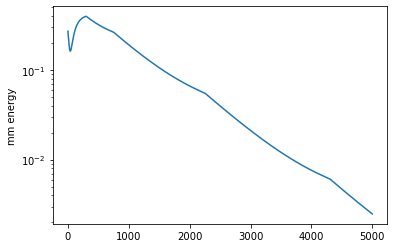

In [4]:
import matplotlib.pyplot as plt
plt.plot(mm_energy)
plt.yscale('log')
plt.ylabel('mm energy')
plt.show()

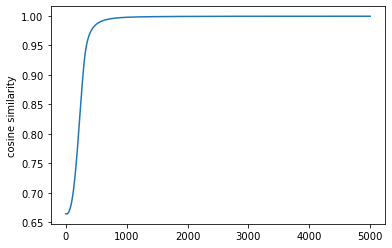

In [5]:
cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()

In [6]:
B_array[-1] @ W 

array([[0.26813835, 0.35385586, 0.18577806],
       [0.50392674, 0.65824502, 0.34859596],
       [0.09792055, 0.12447975, 0.0674609 ]])

# A larger net with 100 -> 10

In [7]:
# define parameters of net
layers = [100, 10]
steps = 5000
bw_lr = 1e-4
alpha = 1e+3
alpha_decay = 1e-1

# after how many steps to eval model
per_steps = 50

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * B)
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy(r, W, B))
    
    # every 50 steps, take average and see if energy doesn't move
    if i % per_steps == 0 and i != 0:
        if np.isnan(mm_energy[-1]) or np.isinf(mm_energy[-1]):
            raise ValueError('mm energy inf or nan')
        print(f'mm energy after {i} steps: {mm_energy[-1]}')
        if mm_energy[-1] < 1e-20:
            print("reached precision of 10^-20")
            break
        if np.sqrt(np.cov(mm_energy[-per_steps:])) < 1e-2 * np.mean(mm_energy[-per_steps:]):
            alpha *= alpha_decay
            print(f'plateau detected, reducing alpha to {alpha}')

mm energy after 50 steps: 0.4345657723219456
mm energy after 100 steps: 0.4345657723219456
plateau detected, reducing alpha to 100.0
mm energy after 150 steps: 0.05074601264526916
mm energy after 200 steps: 0.050746012645269116
plateau detected, reducing alpha to 10.0
mm energy after 250 steps: 0.005161175162890863
mm energy after 300 steps: 0.005161175162890863
plateau detected, reducing alpha to 1.0
mm energy after 350 steps: 0.0005169995297203915
mm energy after 400 steps: 0.0005169995297204287
plateau detected, reducing alpha to 0.1
mm energy after 450 steps: 5.170878968961085e-05
mm energy after 500 steps: 5.170878968956767e-05
plateau detected, reducing alpha to 0.010000000000000002
mm energy after 550 steps: 5.1709673527107075e-06
mm energy after 600 steps: 5.17096735270214e-06
plateau detected, reducing alpha to 0.0010000000000000002
mm energy after 650 steps: 5.170976191892848e-07
mm energy after 700 steps: 5.170976190720666e-07
plateau detected, reducing alpha to 0.0001000000

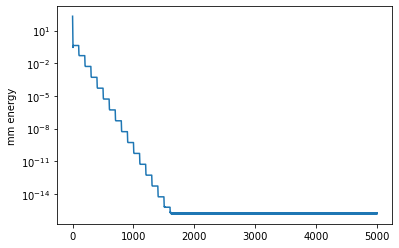

In [8]:
import matplotlib.pyplot as plt
plt.plot(mm_energy)
plt.yscale('log')
plt.ylabel('mm energy')
plt.show()

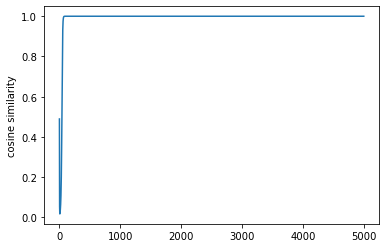

In [9]:
cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()

# The inverse: 10 -> 100

In [10]:
# define parameters of net
layers = [10, 100]
steps = 5000
bw_lr = 1e-3
alpha = 1e+2
alpha_decay = 1e-1

# after how many steps to eval model
per_steps = 50

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * B)
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy(r, W, B))
    
    # every 50 steps, take average and see if energy doesn't move
    if i % per_steps == 0 and i != 0:
        if np.isnan(mm_energy[-1]) or np.isinf(mm_energy[-1]):
            raise ValueError('mm energy inf or nan')
        print(f'mm energy after {i} steps: {mm_energy[-1]}')
        if mm_energy[-1] < 1e-20:
            print("reached precision of 10^-20")
            break
        if np.sqrt(np.cov(mm_energy[-per_steps:])) < 1e-2 * np.mean(mm_energy[-per_steps:]):
            alpha *= alpha_decay
            print(f'plateau detected, reducing alpha to {alpha}')

mm energy after 50 steps: 0.10946633892530927
mm energy after 100 steps: 0.10946633892530941
plateau detected, reducing alpha to 10.0
mm energy after 150 steps: 0.012159717935446592
mm energy after 200 steps: 0.012159717935446509
plateau detected, reducing alpha to 1.0
mm energy after 250 steps: 0.0012295979517695879
mm energy after 300 steps: 0.0012295979517695003
plateau detected, reducing alpha to 0.1
mm energy after 350 steps: 0.00012309773828293442
mm energy after 400 steps: 0.0001230977382828375
plateau detected, reducing alpha to 0.010000000000000002
mm energy after 450 steps: 1.2311154961773427e-05
mm energy after 500 steps: 1.2311154961773466e-05
plateau detected, reducing alpha to 0.0010000000000000002
mm energy after 550 steps: 1.231129309229956e-06
mm energy after 600 steps: 1.2311293091545211e-06
plateau detected, reducing alpha to 0.00010000000000000003
mm energy after 650 steps: 1.231130690025585e-07
mm energy after 700 steps: 1.2311306903757484e-07
plateau detected, red

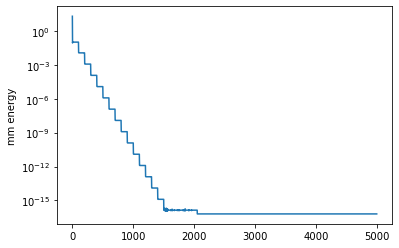

In [11]:
import matplotlib.pyplot as plt
plt.plot(mm_energy)
plt.yscale('log')
plt.ylabel('mm energy')
plt.show()

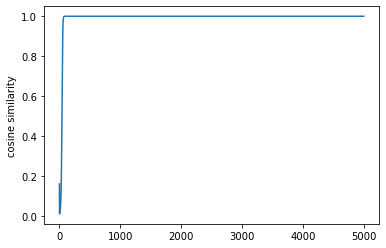

In [12]:
cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()

# A realistic net with 784 -> 500

In [14]:
# define parameters of net
layers = [784, 500]
steps = 5000
bw_lr = 1e-7
alpha = 1e+6
alpha_decay = 1e-1

# after how many steps to eval model
per_steps = 50

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * B)
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy(r, W, B))
    
    # every 50 steps, take average and see if energy doesn't move
    if i % per_steps == 0 and i != 0:
        if np.isnan(mm_energy[-1]) or np.isinf(mm_energy[-1]):
            raise ValueError('mm energy inf or nan')
        print(f'mm energy after {i} steps: {mm_energy[-1]}')
        if mm_energy[-1] < 1e-20:
            print("reached precision of 10^-20")
            break
        if np.sqrt(np.cov(mm_energy[-per_steps:])) < 1e-2 * np.mean(mm_energy[-per_steps:]):
            alpha *= alpha_decay
            print(f'plateau detected, reducing alpha to {alpha}')

mm energy after 50 steps: 1892.1501243292635
mm energy after 100 steps: 6.422853920703528
mm energy after 150 steps: 0.43548792361535305
mm energy after 200 steps: 0.4188650767454203
mm energy after 250 steps: 0.41881218826393823
plateau detected, reducing alpha to 100000.0
mm energy after 300 steps: 0.04397940375685182
mm energy after 350 steps: 0.04397353340505879
plateau detected, reducing alpha to 10000.0
mm energy after 400 steps: 0.004419784461532307
mm energy after 450 steps: 0.004419432254965276
plateau detected, reducing alpha to 1000.0
mm energy after 500 steps: 0.000442198693964058
mm energy after 550 steps: 0.0004421652347126312
plateau detected, reducing alpha to 100.0
mm energy after 600 steps: 4.422207358604494e-05
mm energy after 650 steps: 4.421874479040212e-05
plateau detected, reducing alpha to 10.0
mm energy after 700 steps: 4.42222940226927e-06
mm energy after 750 steps: 4.421896693627619e-06
plateau detected, reducing alpha to 1.0
mm energy after 800 steps: 4.4222

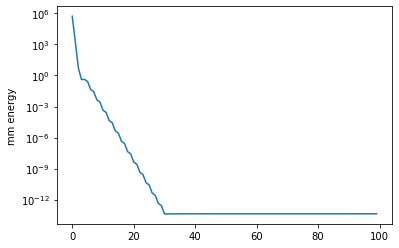

In [30]:
import matplotlib.pyplot as plt
plt.plot(mm_energy[1::50])
plt.yscale('log')
plt.ylabel('mm energy')
plt.show()

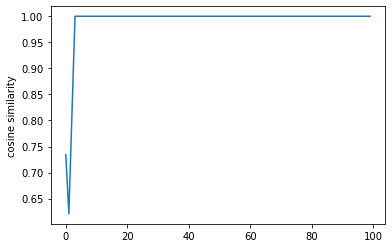

In [29]:
cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array[1::50]]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()